In [120]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve,accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN

from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import xgboost as xgb
import joblib

In [121]:

df = pd.read_csv('Dataset Ph2 Cleaned.csv')

df.head()

,Indexno,AGE,GENDER,RCRI score,Anemia category,PreopEGFRMDRD,GradeofKidneydisease,DaysbetweenDeathandoperation,@30daymortality,Preoptransfusionwithin30days,...,SurgRiskCategory,RaceCategory,CVARCRICategory,IHDRCRICategory,CHFRCRICategory,DMinsulinRCRICategory,CreatinineRCRICategory,RDW15.7,ASAcategorybinned,ICUAdmgt24h
0,111689,21,MALE,0,none,121.195820,G1,0.0,NO,0,...,Low,Chinese,no,no,no,no,no,<= 15.7,II,no
1,110169,20,MALE,1,moderate,124.312948,G1,0.0,NO,0,...,Moderate,Chinese,no,no,no,no,no,<= 15.7,IV-VI,yes
2,100897,29,MALE,0,none,81.442682,G2,0.0,NO,0,...,Low,Chinese,no,no,no,no,no,<= 15.7,I,no
3,2888,21,MALE,0,none,95.740830,G1,0.0,NO,0,...,Low,Others,no,no,no,no,no,<= 15.7,IV-VI,yes
4,113755,20,MALE,1,moderate,209.898261,G1,218.0,NO,0,...,Low,Chinese,no,no,no,no,no,>15.7,III,yes


In [122]:
df.shape

(11658, 27)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11658 entries, 0 to 11657
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Indexno                       11658 non-null  int64  
 1   AGE                           11658 non-null  int64  
 2   GENDER                        11658 non-null  object 
 3   RCRI score                    11658 non-null  int64  
 4   Anemia category               11658 non-null  object 
 5   PreopEGFRMDRD                 11658 non-null  float64
 6   GradeofKidneydisease          11658 non-null  object 
 7   DaysbetweenDeathandoperation  11658 non-null  float64
 8   @30daymortality               11658 non-null  object 
 9   Preoptransfusionwithin30days  11658 non-null  int64  
 10  Intraop                       11658 non-null  int64  
 11  Postopwithin30days            11658 non-null  int64  
 12  Transfusionintraandpostop     11658 non-null  int64  
 13  A

In [124]:
# Display unique values of the 'Transfusionintraandpostop' feature
print(df['Transfusionintraandpostop'].unique())

[ 0  1  3  2  6  4 16  8  5  7 13]


In [125]:
df.describe()

,Indexno,AGE,RCRI score,PreopEGFRMDRD,DaysbetweenDeathandoperation,Preoptransfusionwithin30days,Intraop,Postopwithin30days,Transfusionintraandpostop
count,11658.000000,11658.000000,11658.000000,11658.000000,11658.000000,11658.000000,11658.000000,11658.000000,11658.000000
mean,58021.247041,54.412764,0.383170,96.787674,27.231429,0.084920,0.074284,0.028907,0.103191
std,33741.646354,16.569153,0.702413,35.569949,141.217260,0.600672,0.262243,0.323676,0.476510
min,10.000000,18.000000,0.000000,2.541026,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29181.500000,43.000000,0.000000,79.086322,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56974.000000,56.000000,0.000000,96.512521,0.000000,0.000000,0.000000,0.000000,0.000000
75%,85297.500000,67.000000,1.000000,115.102031,0.000000,0.000000,0.000000,0.000000,0.000000
max,121188.000000,99.000000,5.000000,588.466578,1783.000000,13.000000,1.000000,15.000000,16.000000


In [126]:
df = df.drop(columns=['Mortality','Indexno','RaceCategory','CVARCRICategory'],axis=1)

##### transformation

In [127]:
cat_cols = [x for x in df.columns if df[x].dtype == 'object']
num_cols = [x for x in df.columns if df[x].dtype != 'object']
print(cat_cols)

['GENDER', 'Anemia category', 'GradeofKidneydisease', '@30daymortality', 'AnaestypeCategory', 'PriorityCategory', 'AGEcategory', 'SurgRiskCategory', 'IHDRCRICategory', 'CHFRCRICategory', 'DMinsulinRCRICategory', 'CreatinineRCRICategory', 'RDW15.7', 'ASAcategorybinned', 'ICUAdmgt24h']


In [128]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30, kde=True)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist='norm', plot=plt)
    plt.ylabel('\n' + variable + ' quantities')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


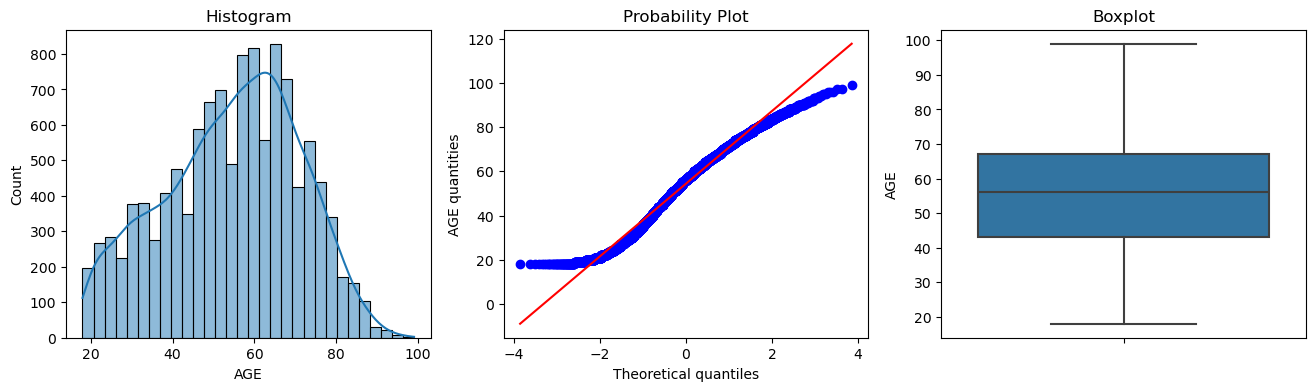

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


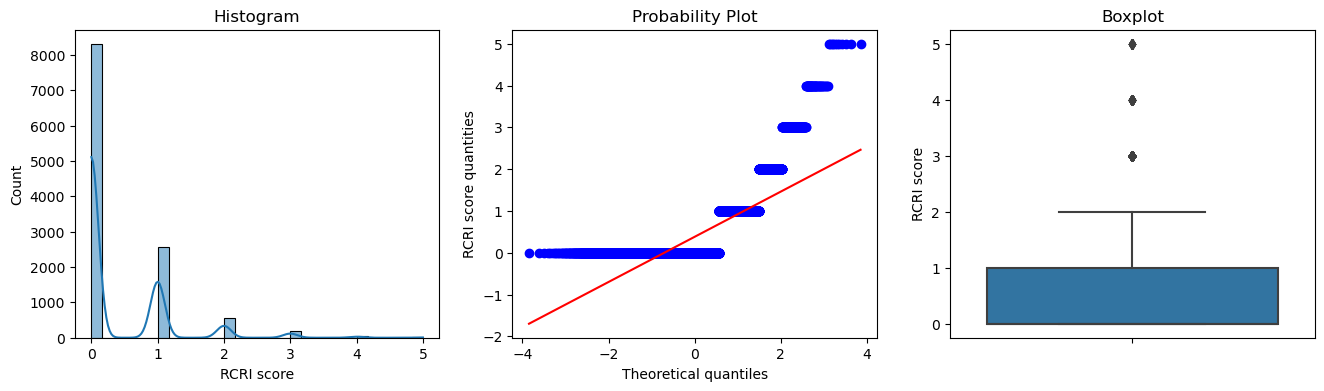

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


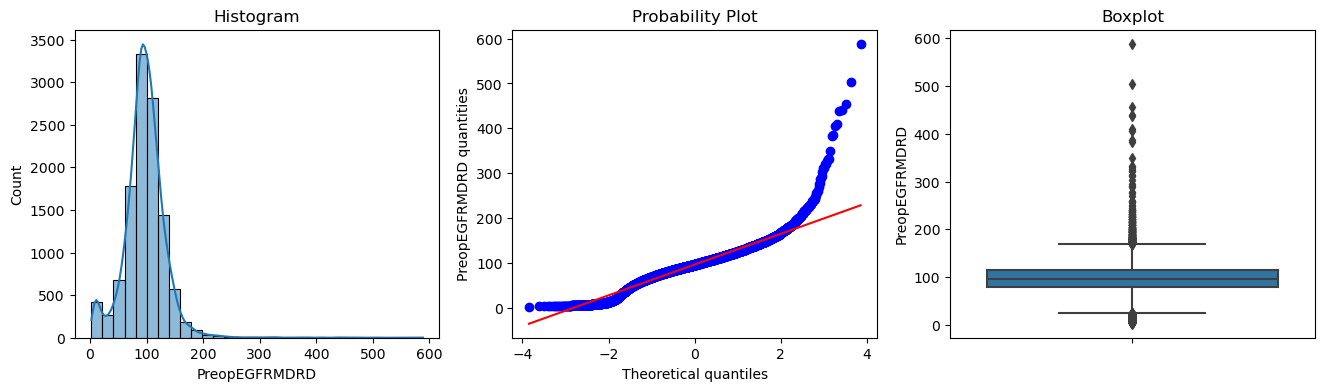

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


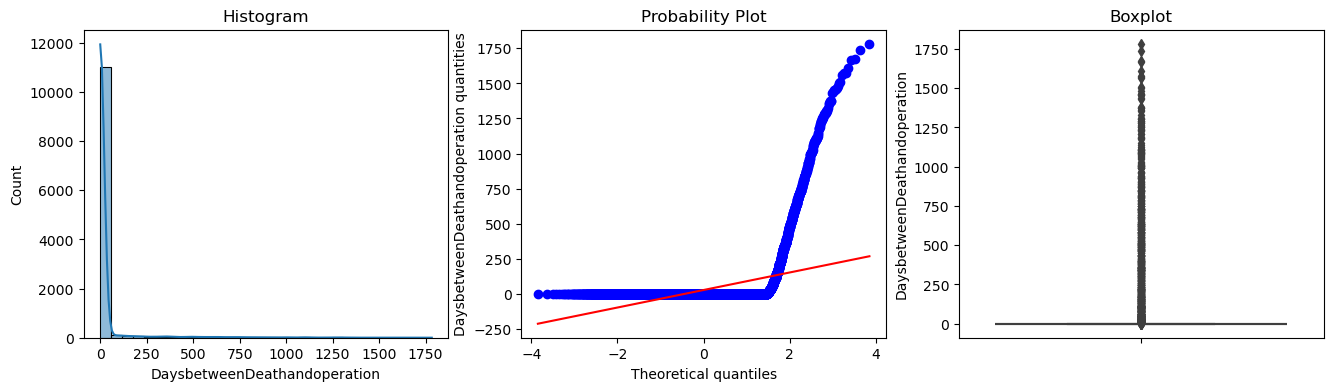

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


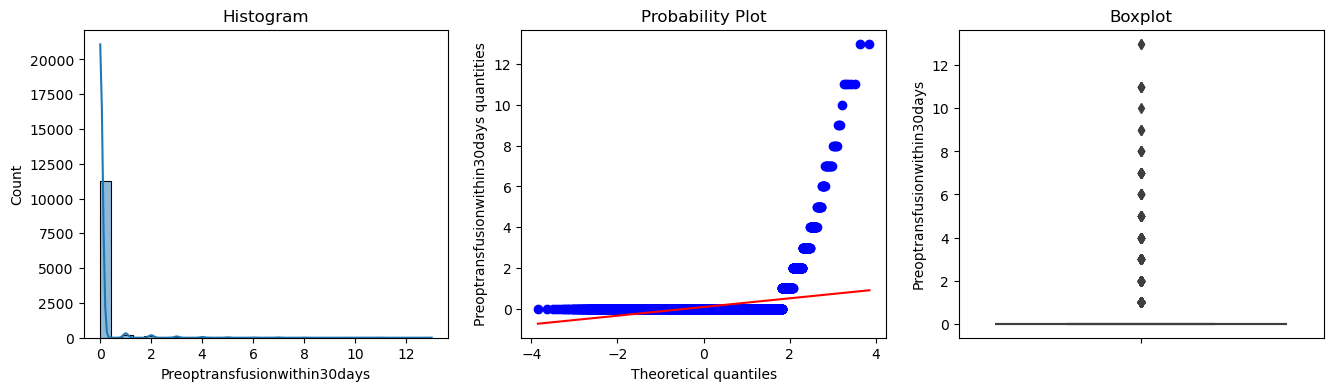

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


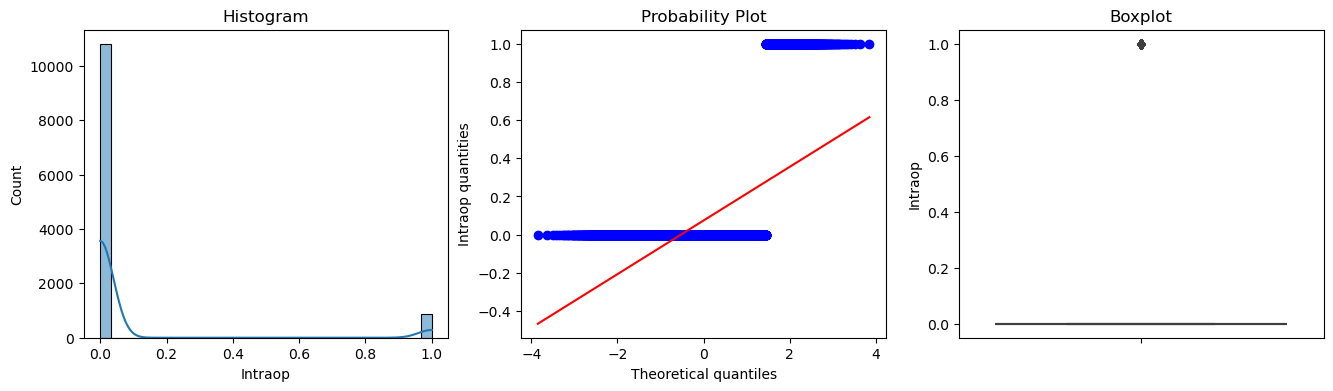

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


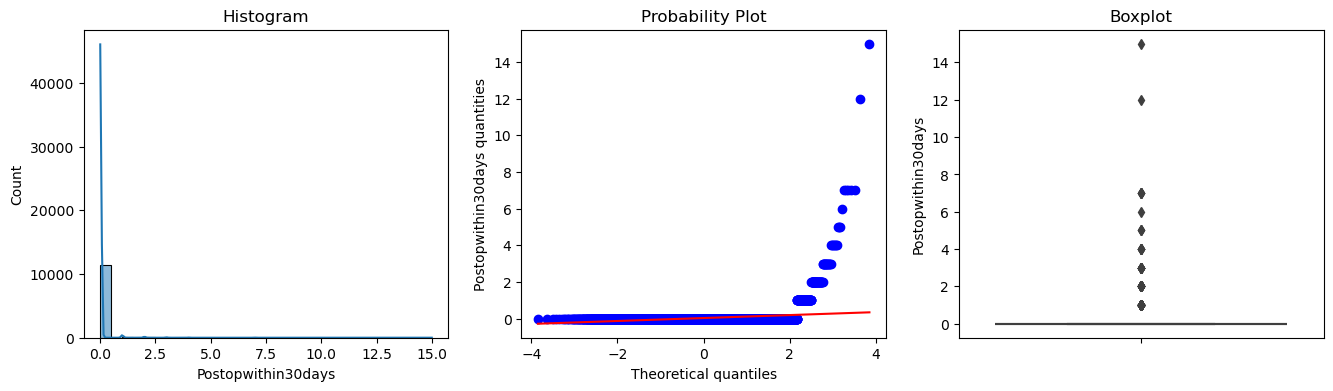

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


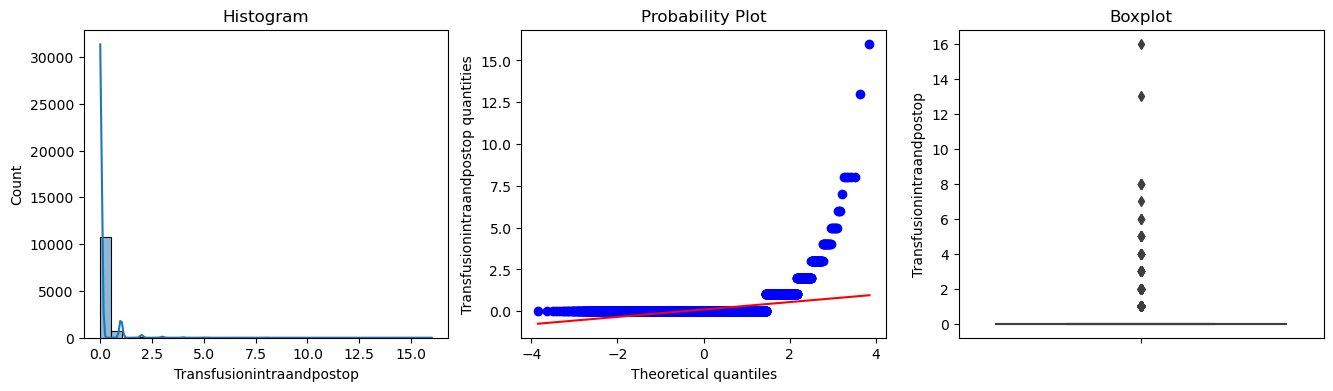

In [129]:
for col in num_cols:
    diagnostic_plots(df,col)

In [130]:
def trim_outliers(data,col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Trim outliers
    trimmed_data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

    return trimmed_data 

In [131]:
df = trim_outliers(df,'PreopEGFRMDRD')
df.shape

(10956, 23)

In [132]:
df = df.drop(columns=['PreopEGFRMDRD'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10956 entries, 0 to 11657
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   AGE                           10956 non-null  int64  
 1   GENDER                        10956 non-null  object 
 2   RCRI score                    10956 non-null  int64  
 3   Anemia category               10956 non-null  object 
 4   GradeofKidneydisease          10956 non-null  object 
 5   DaysbetweenDeathandoperation  10956 non-null  float64
 6   @30daymortality               10956 non-null  object 
 7   Preoptransfusionwithin30days  10956 non-null  int64  
 8   Intraop                       10956 non-null  int64  
 9   Postopwithin30days            10956 non-null  int64  
 10  Transfusionintraandpostop     10956 non-null  int64  
 11  AnaestypeCategory             10956 non-null  object 
 12  PriorityCategory              10956 non-null  object 
 13  AGEcat

##### encoding

In [133]:
label_enc = LabelEncoder()

print('encoded values : \n')

for col in cat_cols:
    df[col] = label_enc.fit_transform(df[col])
    value_dict = {label: index for index, label in enumerate(label_enc.classes_)}
    print(f'{col} : {value_dict}')


encoded values : 

GENDER : {'FEMALE': 0, 'MALE': 1}
Anemia category : {'mild': 0, 'moderate': 1, 'none': 2, 'severe': 3}
GradeofKidneydisease : {'G1': 0, 'G2': 1, 'G3a': 2, 'G3b': 3, 'G4': 4}
@30daymortality : {'NO': 0, 'YES': 1}
AnaestypeCategory : {'GA': 0, 'RA': 1}
PriorityCategory : {'Elective': 0, 'Emergency': 1}
AGEcategory : {'18-29': 0, '30-49': 1, '50-64': 2, '65-74': 3, '75-84': 4, '>=85': 5}
SurgRiskCategory : {'High': 0, 'Low': 1, 'Moderate': 2}
IHDRCRICategory : {'no': 0, 'yes': 1}
CHFRCRICategory : {'no': 0, 'yes': 1}
DMinsulinRCRICategory : {'no': 0, 'yes': 1}
CreatinineRCRICategory : {'no': 0, 'yes': 1}
RDW15.7 : {'<= 15.7': 0, '>15.7': 1}
ASAcategorybinned : {'I': 0, 'II': 1, 'III': 2, 'IV-VI': 3}
ICUAdmgt24h : {'no': 0, 'yes': 1}


In [134]:
target_variables = ['@30daymortality', 'ICUAdmgt24h']

df = df[[col for col in df.columns if col not in target_variables] + target_variables]

df.head()

,AGE,GENDER,RCRI score,Anemia category,GradeofKidneydisease,DaysbetweenDeathandoperation,Preoptransfusionwithin30days,Intraop,Postopwithin30days,Transfusionintraandpostop,...,AGEcategory,SurgRiskCategory,IHDRCRICategory,CHFRCRICategory,DMinsulinRCRICategory,CreatinineRCRICategory,RDW15.7,ASAcategorybinned,@30daymortality,ICUAdmgt24h
0,21,1,0,2,0,0.0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,20,1,1,1,0,0.0,0,0,0,0,...,0,2,0,0,0,0,0,3,0,1
2,29,1,0,2,1,0.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,21,1,0,2,0,0.0,0,0,0,0,...,0,1,0,0,0,0,0,3,0,1
5,23,1,0,2,0,0.0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [135]:
df.columns

Index(['AGE', 'GENDER', 'RCRI score', 'Anemia category',
       'GradeofKidneydisease', 'DaysbetweenDeathandoperation',
       'Preoptransfusionwithin30days', 'Intraop', 'Postopwithin30days',
       'Transfusionintraandpostop', 'AnaestypeCategory', 'PriorityCategory',
       'AGEcategory', 'SurgRiskCategory', 'IHDRCRICategory', 'CHFRCRICategory',
       'DMinsulinRCRICategory', 'CreatinineRCRICategory', 'RDW15.7',
       'ASAcategorybinned', '@30daymortality', 'ICUAdmgt24h'],
      dtype='object')

##### split and sample data

In [136]:
X = df.drop(columns=['@30daymortality', 'RCRI score', 'Anemia category',
       'GradeofKidneydisease',
       'Preoptransfusionwithin30days', 'Intraop', 'Postopwithin30days',
       'DaysbetweenDeathandoperation', 'PriorityCategory',
       'AGEcategory', 'IHDRCRICategory','CreatinineRCRICategory', 'RDW15.7',
       'ASAcategorybinned', 'ICUAdmgt24h'])  # features
y = df[['@30daymortality']]  # target variables

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)

In [138]:
y_train['@30daymortality'].value_counts()

@30daymortality
0    7606
1      63
Name: count, dtype: int64

In [139]:
# undersample majority class

under_sampler = RandomUnderSampler(sampling_strategy= 0.1, random_state=7)
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train, y_train)

smoteenn = SMOTEENN(sampling_strategy=1, random_state=7)
X_train_oversampled, y_train_oversampled = smoteenn.fit_resample(X_train_undersampled, y_train_undersampled)

print('original shape of data : {} , {}'.format(X_train.shape, y_train.shape))
print('original value count: \n {} \n'.format(y_train.value_counts()))

print('after undersampling shape of data : {} , {}'.format(X_train_undersampled.shape, y_train_undersampled.shape))
print('after undersampling value count: \n {}'.format(y_train_undersampled.value_counts()))

print('after smoteenn shape of data : {} , {}'.format(X_train_oversampled.shape, y_train_oversampled.shape))
print('after smoteenn value count: \n {}'.format(y_train_oversampled.value_counts()))

original shape of data : (7669, 7) , (7669, 1)
original value count: 
 @30daymortality
0                  7606
1                    63
Name: count, dtype: int64 

after undersampling shape of data : (693, 7) , (693, 1)
after undersampling value count: 
 @30daymortality
0                  630
1                   63
Name: count, dtype: int64
after smoteenn shape of data : (931, 7) , (931, 1)
after smoteenn value count: 
 @30daymortality
0                  501
1                  430
Name: count, dtype: int64


In [140]:
X_train_resampled = X_train_oversampled
y_train_resampled = y_train_oversampled

In [141]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

y_train_resampled = np.ravel(y_train_resampled)

In [142]:
y_test['@30daymortality'].value_counts()

@30daymortality
0    3260
1      27
Name: count, dtype: int64

##### logistic regression

In [143]:
logreg = LogisticRegression(class_weight='balanced',solver='liblinear',penalty='l2')

logreg.fit(X_train_resampled,y_train_resampled)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [144]:

print(logreg.score(X_train_resampled, y_train_resampled), '(Train Accuracy)')
print(logreg.score(X_test, y_test), '(Test Accuracy)')

0.9065520945220193 (Train Accuracy)
0.7937328871311226 (Test Accuracy)


[[2588  672]
 [   6   21]]


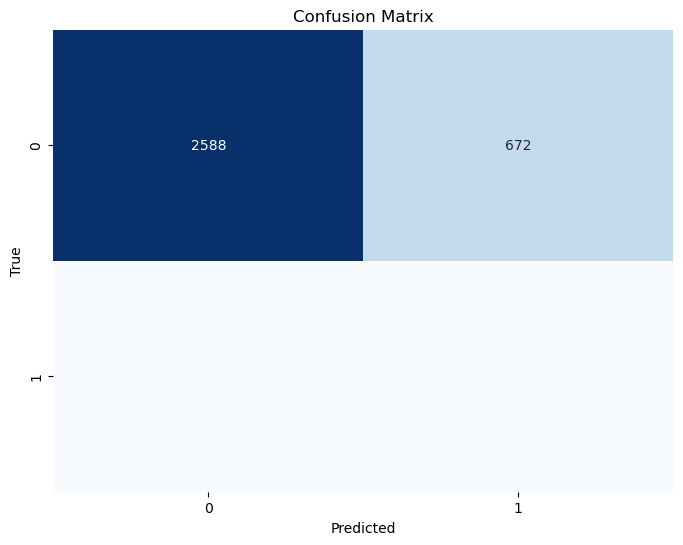

In [145]:
y_pred = logreg.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

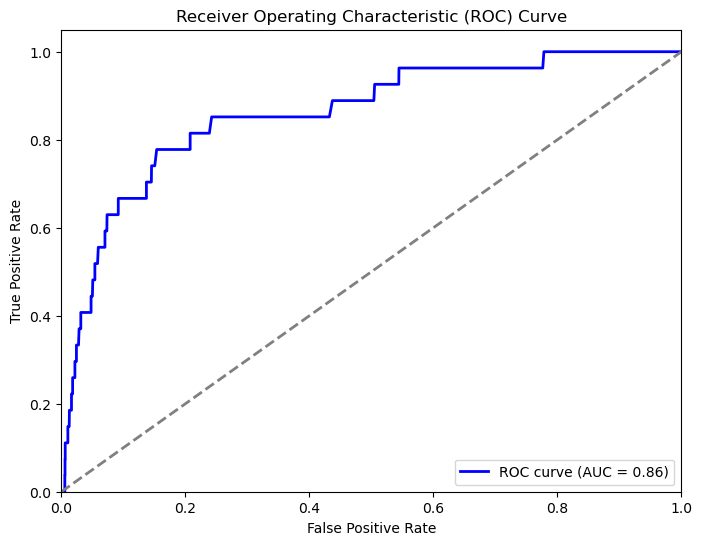

In [146]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### mlp

In [147]:
mlp = MLPClassifier(activation ='logistic', hidden_layer_sizes=(10,), max_iter= 2000, solver = 'sgd', random_state=7)
# Fit the #### ANN Model#### ANN Modelmodel to the training set
mlp.fit(X_train_resampled,y_train_resampled)

MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), max_iter=2000,
              random_state=7, solver='sgd')

In [148]:
y_fitted = mlp.predict(X_train_resampled) # returns 0 or 1
y_fitted_prob = mlp.predict_proba(X_train_resampled)[:,0] # returns probabilities

print(mlp.score(X_train_resampled, y_train_resampled), '(Train Accuracy)')
print(mlp.score(X_test, y_test), '(Test Accuracy)')

0.9151450053705693 (Train Accuracy)
0.7995132339519319 (Test Accuracy)


In [149]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Predictions on the test set
y_test_pred = mlp.predict(X_test)

# Classification report
print(classification_report(y_test, y_test_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      3260
           1       0.03      0.74      0.06        27

    accuracy                           0.80      3287
   macro avg       0.51      0.77      0.47      3287
weighted avg       0.99      0.80      0.88      3287

[[2608  652]
 [   7   20]]


In [150]:
# Save the model to a file
joblib.dump(mlp, 'mortality_mlp_model.pkl')

['mortality_mlp_model.pkl']

In [151]:
# Save the feature names for reference
feature_names = X.columns
joblib.dump(feature_names, 'feature_names.pkl')

['feature_names.pkl']

In [152]:
X.columns

Index(['AGE', 'GENDER', 'Transfusionintraandpostop', 'AnaestypeCategory',
       'SurgRiskCategory', 'CHFRCRICategory', 'DMinsulinRCRICategory'],
      dtype='object')

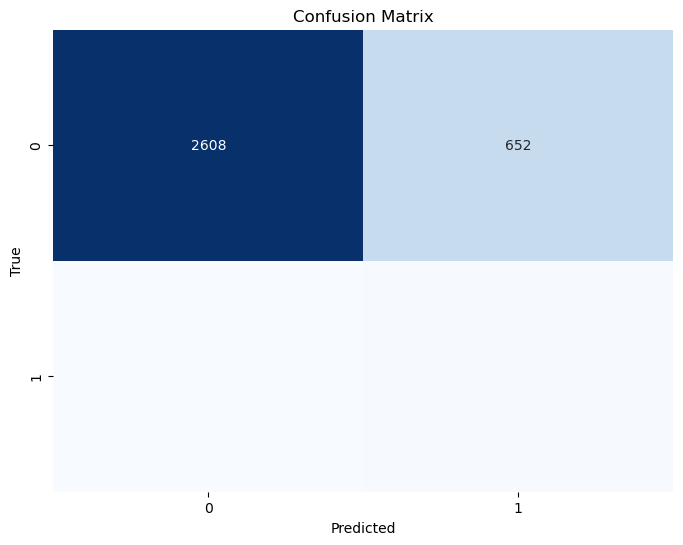

In [153]:
y_pred = mlp.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

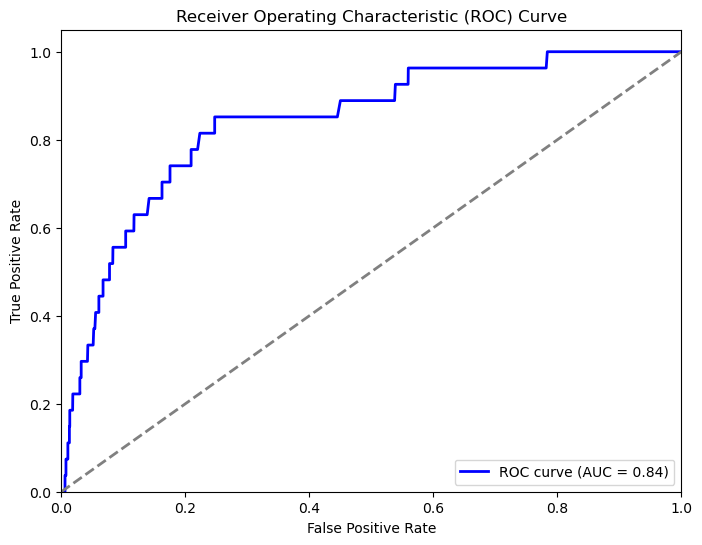

In [154]:
y_pred_prob = mlp.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

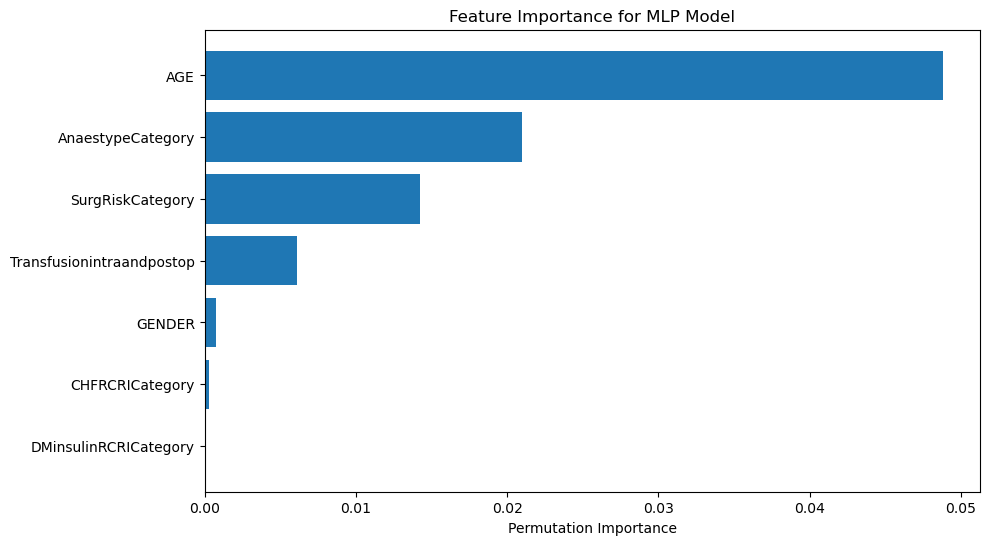

In [155]:
from sklearn.inspection import permutation_importance
#Assuming mlp is your trained MLP model and X_test, y_test are your test data
result = permutation_importance(mlp, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the feature importances
feature_importances = result.importances_mean

# Sort the features by importance
sorted_idx = feature_importances.argsort()

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance for MLP Model")
plt.show()

##### XGBoost



In [102]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgboost = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=7, use_label_encoder=False, eval_metric='logloss')
xgboost.fit(X_train_resampled,y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=7, ...)

In [103]:
y_pred = xgboost.predict(X_test)
y_proba = xgboost.predict_proba(X_test)[:, 1]

In [104]:
print(xgboost.score(X_train_resampled, y_train_resampled), '(Train Accuracy)')
print(xgboost.score(X_test, y_test), '(Test Accuracy)')

0.9990224828934506 (Train Accuracy)
0.8147246729540615 (Test Accuracy)


In [105]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3260
           1       0.03      0.70      0.06        27

    accuracy                           0.81      3287
   macro avg       0.51      0.76      0.48      3287
weighted avg       0.99      0.81      0.89      3287

ROC-AUC: 0.8784764826175868
PR-AUC: 0.10083849955376349


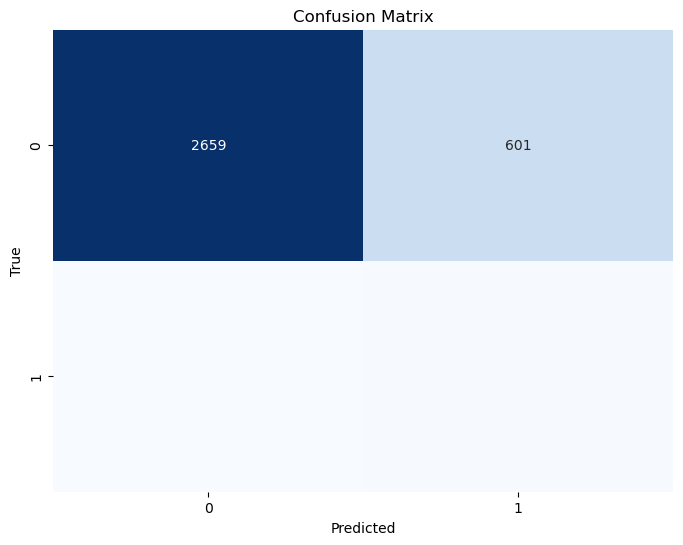

In [106]:
y_pred = xgboost.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


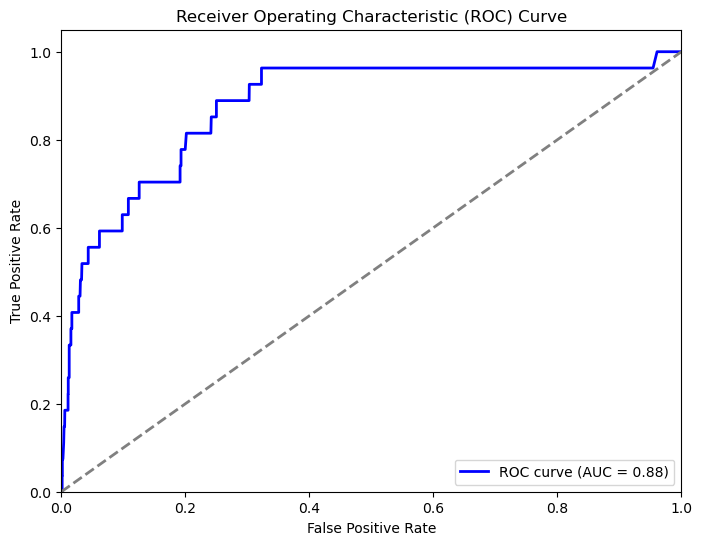

In [107]:
y_pred_prob = xgboost.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [108]:
# Perform cross-validation to get accuracy scores
accuracy_scores = cross_val_score(xgboost, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

# Print cross-validation accuracy scores
print("Cross-validated Accuracy Scores:", accuracy_scores)

# Compute and print mean and standard deviation of accuracy scores
print("Mean Accuracy:", accuracy_scores.mean())
print("Standard Deviation of Accuracy:", accuracy_scores.std())

Cross-validated Accuracy Scores: [0.9902439  0.97560976 0.9902439  0.99019608 0.99509804]
Mean Accuracy: 0.9882783357245337
Standard Deviation of Accuracy: 0.0066091740418913


##### random forest

In [109]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=7)
rf_classifier.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=7)

In [110]:
print(rf_classifier.score(X_train_resampled, y_train_resampled), '(Train Accuracy)')
print(rf_classifier.score(X_test, y_test), '(Test Accuracy)')

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

1.0 (Train Accuracy)
0.8433221782780651 (Test Accuracy)
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3260
           1       0.03      0.70      0.06        27

    accuracy                           0.81      3287
   macro avg       0.51      0.76      0.48      3287
weighted avg       0.99      0.81      0.89      3287



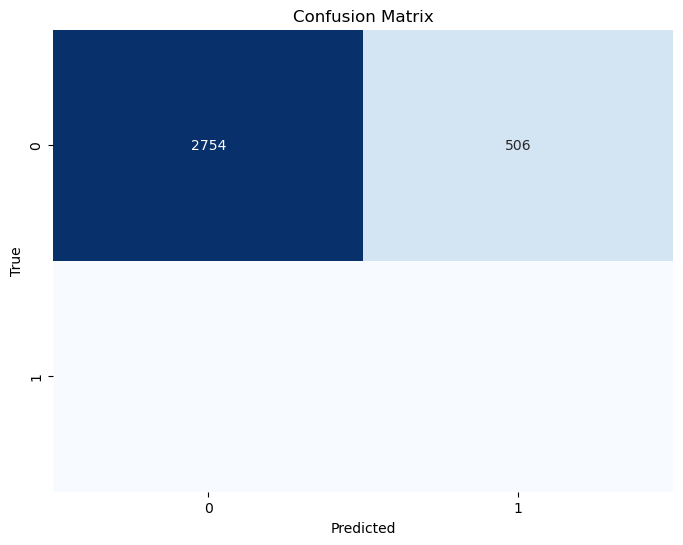

In [111]:
y_pred = rf_classifier.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()